In [135]:
import os
import random
import spacy


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from matplotlib.colors import ListedColormap
from umap.umap_ import UMAP
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
from pointgrid import align_points_to_grid




In [16]:
user_path = 'data/users.csv'
user_df = pd.read_csv(user_path)

# freihand_path = 'data/hertziana_exp/freihand_signatures.csv'
# freihand = pd.read_csv(freihand_path)
# merged_df = user_df.merge(freihand, left_on='Z30_CALL_NO', right_on='signature', how='left').drop_duplicates()

In [30]:
user_df.sample(1)

Z30_CALL_NO Z30_COLLECTION                     Z30_BARCODE   
302349  KatE-FIR 1810-2007/8          BIB    E0040100441F7B0F                \

       Z30_INVENTORY_NUMBER Z30_DESCRIPTION  Z30_NO_LOANS Z36H_LOAN_DATE   
302349             2008.280             NaN           4.0     2016-11-30  \

       Z36H_RETURNED_DATE       Z36H_ID Z36H_LOAN_CATALOGER_NAME   
302349         2016-11-30  MPG000012907               SELFCHECK   \

                Z13_TITLE  Year  
302349  La linea del sole  2016

# Books

Time written, time bought, time loaned
title
subjects (gnd?)
users

frequency: linear regression: years/months: with frequency used (how many users), 

sig, title, frequency (how many users total), type (collection), years: {2013: 4, ...}, users: [all the ids...], freq_norm

In [120]:
grouped = user_df.groupby('Z30_CALL_NO')

frequency = grouped.Z36H_ID.count()
title = grouped.Z13_TITLE.unique().apply(lambda x : x[0])
users = grouped.Z36H_ID.unique().apply(list)
type = grouped.Z30_COLLECTION.unique().apply(lambda x : x[0])
years = grouped['Year'].value_counts().reset_index().groupby('Z30_CALL_NO').apply(lambda group: dict(zip(group['Year'], group['count'])))


df = pd.DataFrame(columns=['frequency', 'frequency_norm', 'slope', 'users', 'type', 'years', 'title'])
df['frequency'] = frequency
df['users'] = users
df['type'] = type
df['years'] = years
df['title'] = title
df.reset_index(inplace=True)

In [121]:
df.sample(1)

Z30_CALL_NO  frequency frequency_norm slope   
73268  Mb 750-6074          5            NaN   NaN  \

                                                   users   type   
73268  [BHR-646     , MPG000012827, MPG000012885, MPG...  BIB    \

                                      years                           title  
73268  {2018: 2, 2019: 1, 2017: 1, 2016: 1}  The artificial and the natural

# Normalization

In [122]:
# Frequency scale

frequency = df["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
df["frequency_norm"] = frequency_scaled


# Linear Regression

In [123]:
def calculate_slope(years):
    x = list(years.keys())
    x = np.array(x).reshape((-1, 1))  # Reshape for one-column values
    y = list(years.values())
    regression = LinearRegression()
    regression.fit(x, y)
    return regression.coef_[0]
df['slope'] = df['years'].apply(calculate_slope)



In [124]:
df.sample(1)

Z30_CALL_NO  frequency  frequency_norm  slope           users   
9605  Ca-ANG 1680-5980          2        0.000431    0.0  [MPG000012901]  \

       type      years                 title  
9605  BIB    {2016: 2}  Sofonisba Anguissola

# Colors

In [144]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

df['color'] = df['slope'].apply(lambda s :cmap(norm(s)) )

In [145]:
df.sample(1)

Z30_CALL_NO  frequency  frequency_norm  slope           users   
66702  KatV-PIT 7565-5953          1             0.0    0.0  [MPG000012870]  \

        type      years                  title   
66702  MAG    {2015: 1}  Da un antico castello  \

                                                   color    x    y  
66702  (0.8674276350862745, 0.864376599772549, 0.8626...  772  577

# Embedding

In [162]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
X = vectorizer.fit_transform(df['users'])

def identity_tokenizer(doc):
    return doc
tfidf = TfidfVectorizer(tokenizer = identity_tokenizer, preprocessor= identity_tokenizer, token_pattern=None)
tfidf_matrix = tfidf.fit_transform(df['users'])



/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [163]:
reducer = UMAP(n_components=2)

embedding = reducer.fit_transform(X)
# embedding = align_points_to_grid(embedding)  # Alignment to a grid
scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

df = df.assign(x=embedding[:, 0], y=embedding[:, 1])

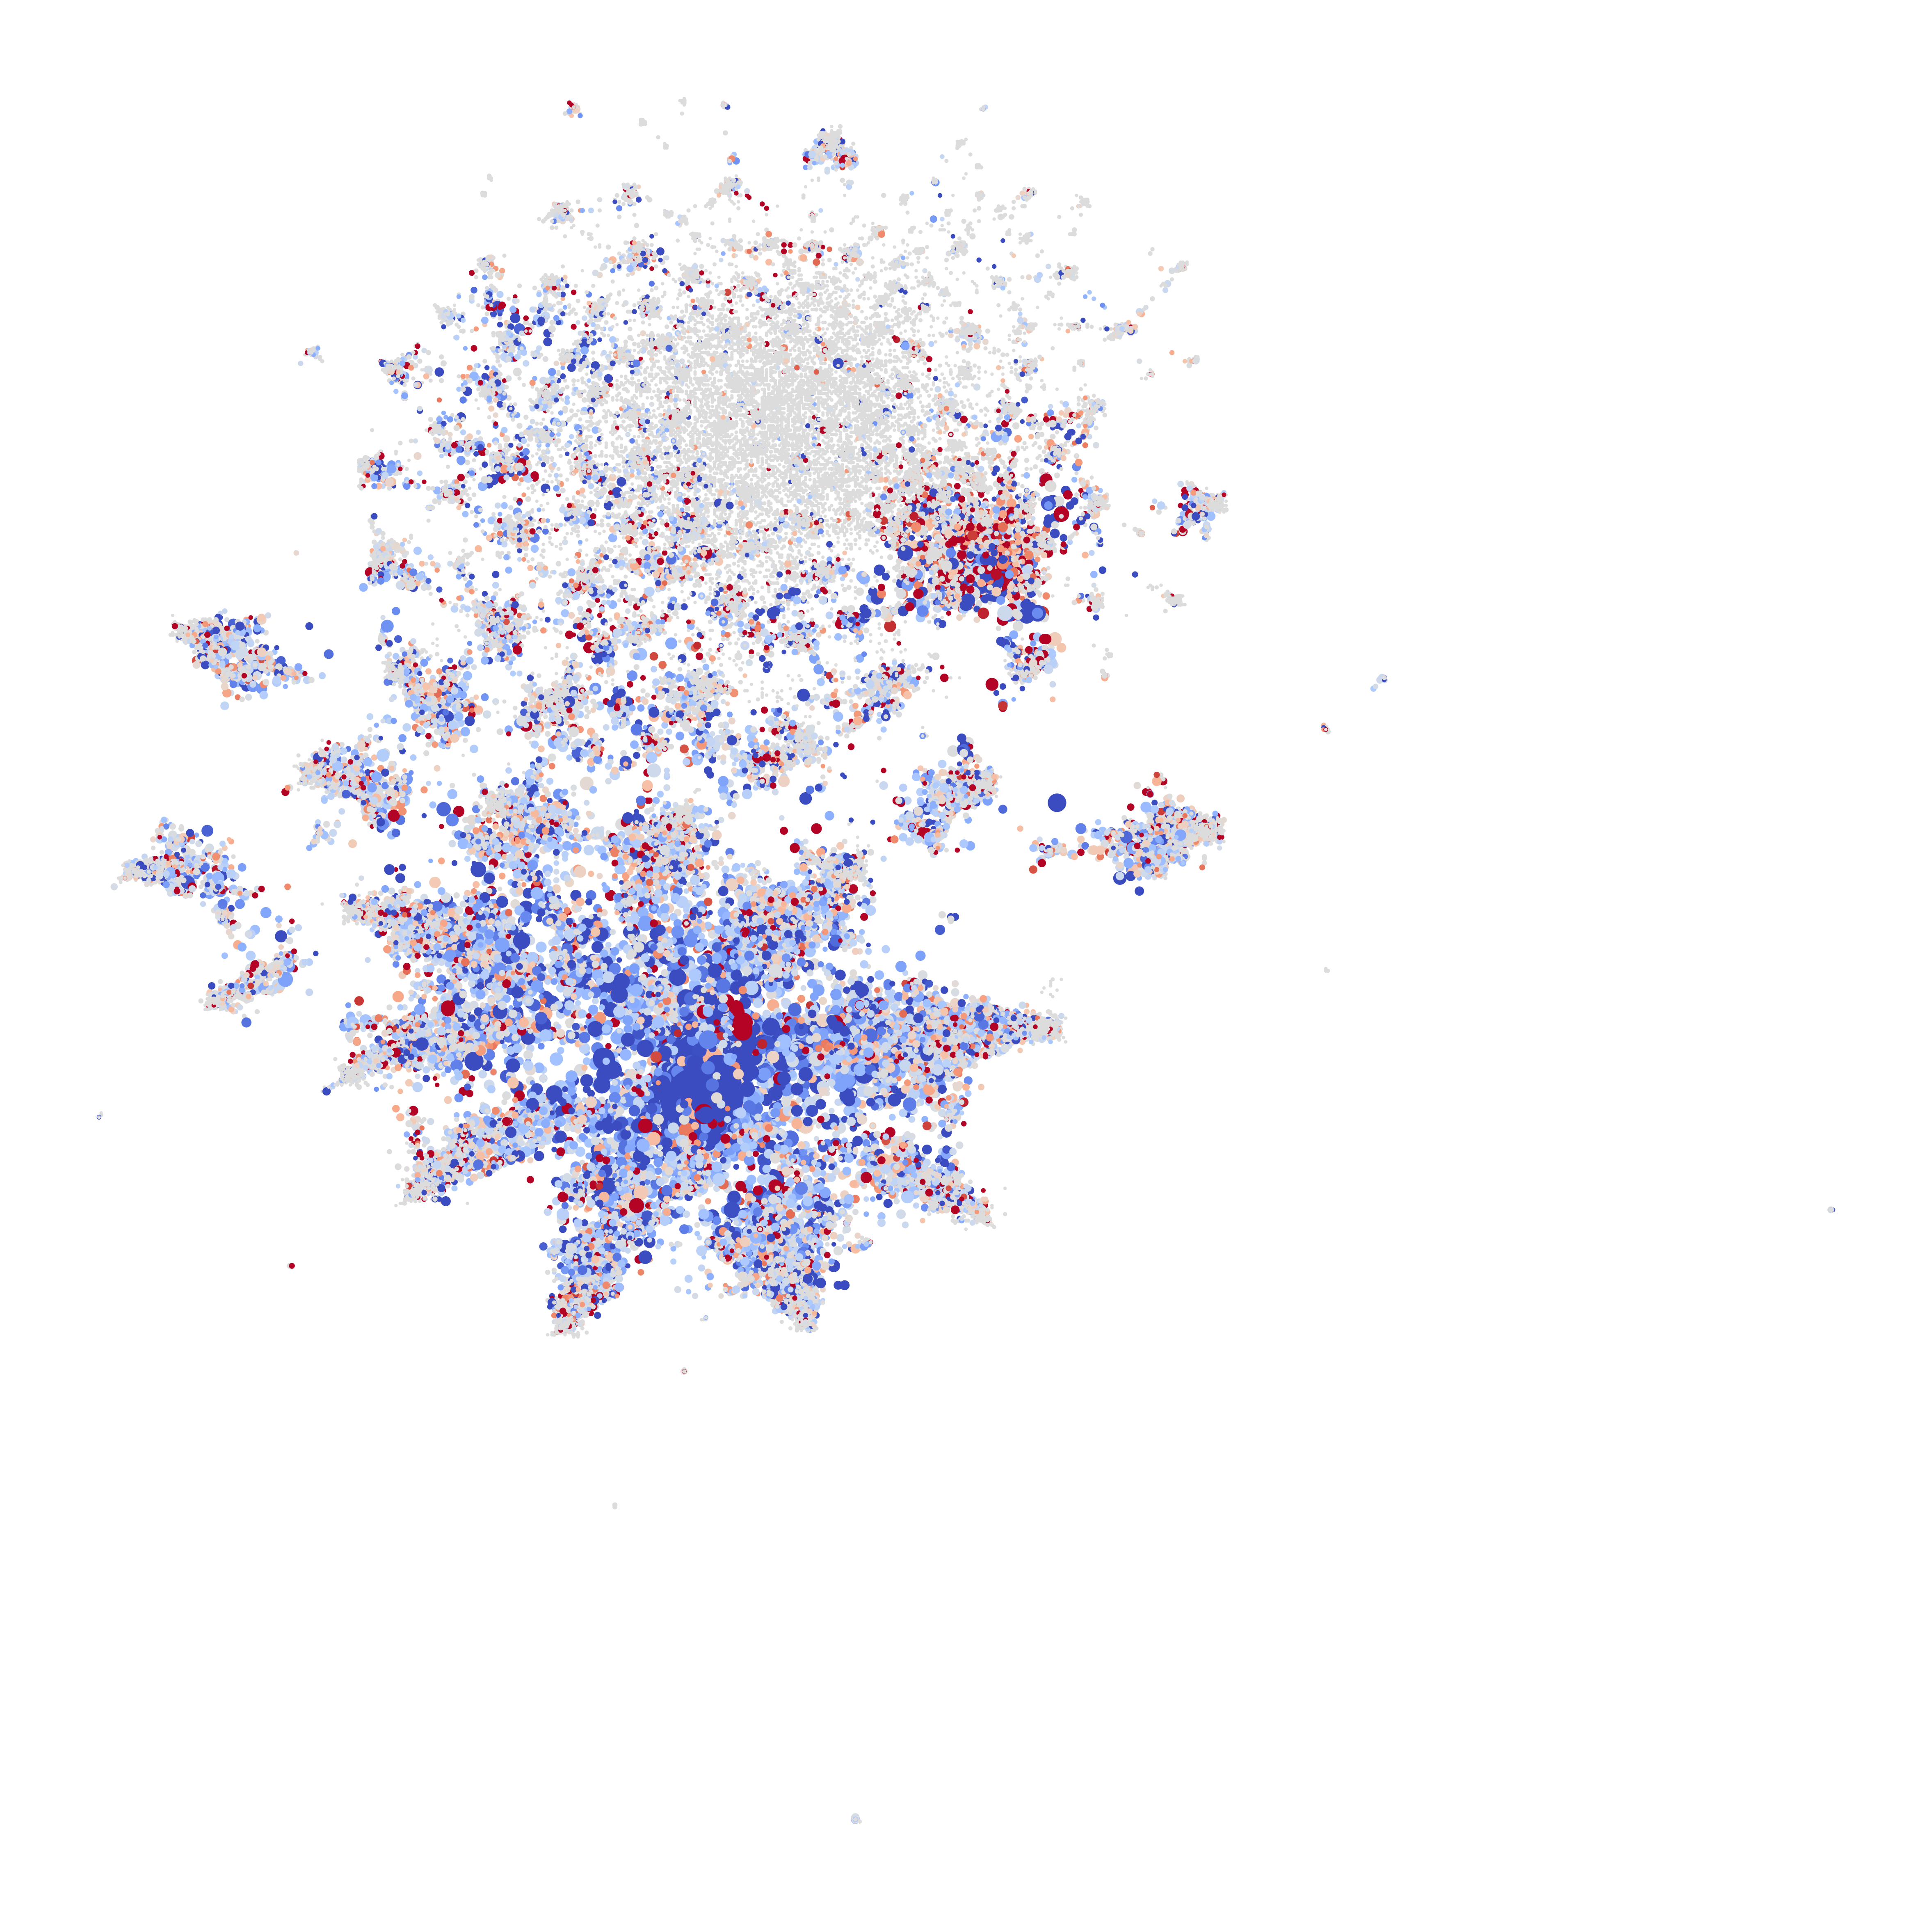

In [164]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=df["frequency"].to_list(),
    c=df["color"].to_list(),
)

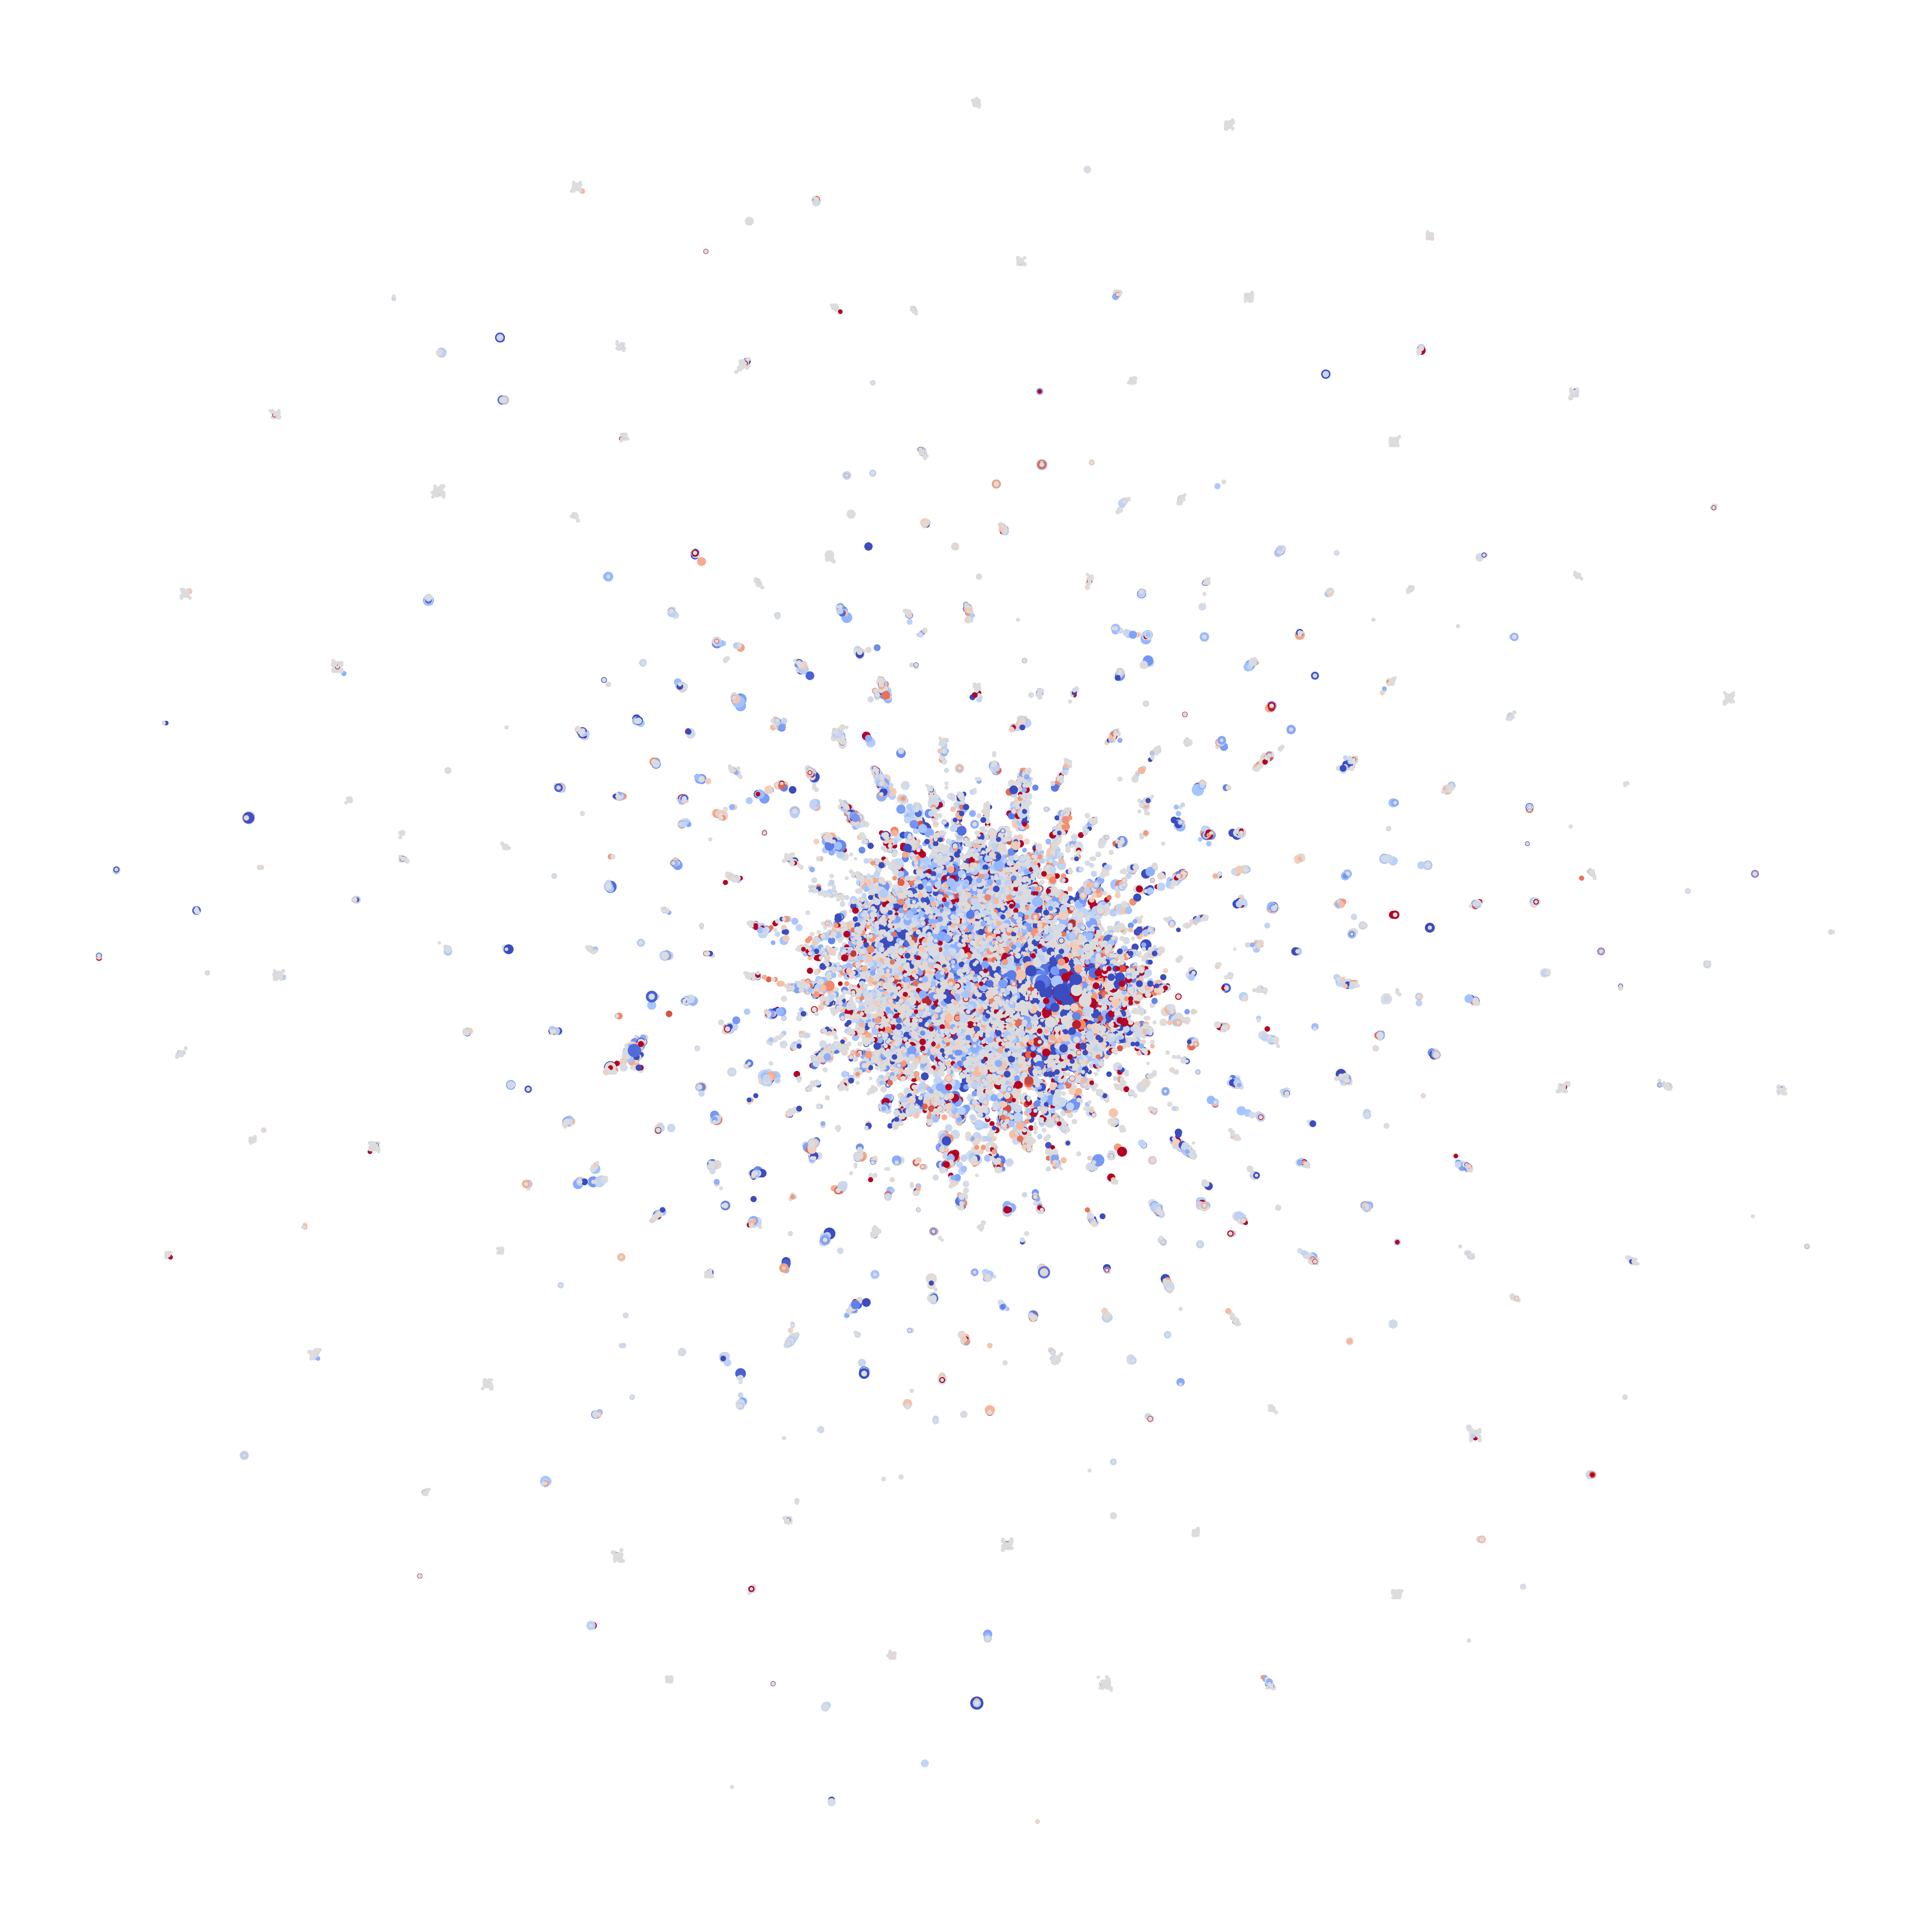

In [161]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=df["frequency"].to_list(),
    c=df["color"].to_list(),
)


/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


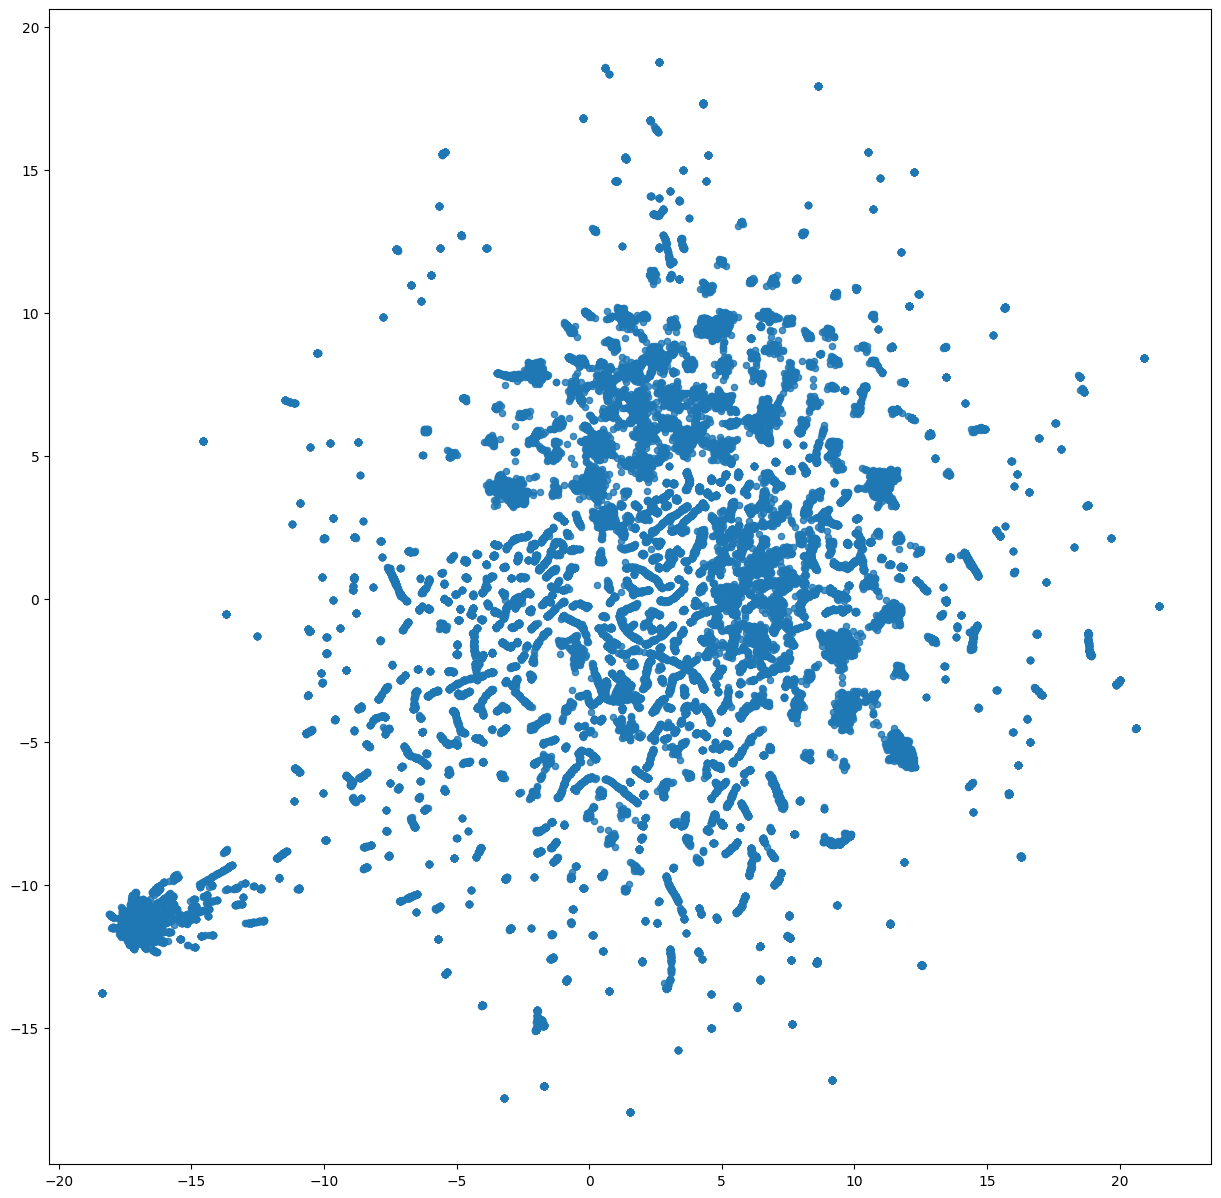

In [21]:


df['Z36H_LOAN_DATE'] = pd.to_datetime(df['Z36H_LOAN_DATE'])
df['Z36H_RETURNED_DATE'] = pd.to_datetime(df['Z36H_RETURNED_DATE'])

df['LOAN_TIME'] = (df['Z36H_RETURNED_DATE'] - df['Z36H_LOAN_DATE']).dt.days + 1 # Minimum Loan time of 1 day

oh = pd.get_dummies(df[['Z30_CALL_NO', 'Z36H_ID','LOAN_TIME']], columns=['Z36H_ID'])
weights = oh[['Z30_CALL_NO', 'LOAN_TIME']]

weights.set_index('Z30_CALL_NO', inplace=True)
oh.set_index('Z30_CALL_NO', inplace=True)

weighted = oh.mul(weights['LOAN_TIME'], axis= 0)
weighted.drop(columns='LOAN_TIME', inplace=True)

grouped = weighted.groupby('Z30_CALL_NO').sum()

umap = UMAP(n_components=2).fit_transform(grouped)

fig, ax = plt.subplots(figsize=(15, 15))

plt.scatter(umap[:, 0], umap[:, 1], s=20, alpha=0.8)
plt.show()

